# Machine Learning

In [3]:
# TODO: Find a better way to deal with the warnings
import warnings
warnings.filterwarnings("ignore")

# Same old imports
import numpy as np
import pandas as pd
import os
import pandas_profiling as pdp
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import matplotlib.pylab as plt
from hyperopt import hp, tpe, Trials
from hyperopt.fmin import fmin
from tqdm import tqdm
import itertools

# Models
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from tpot import TPOTClassifier

In [4]:
# Some constants
DATA_PATH = "Pokemon.csv"
TARGET_COL = "Type 1"
ENCODED_TARGET_COL = "encoded_type_1"
TO_DROP_COLS = ["#", "Name"]
# The dataset is small
TEST_RATIO = 0.1
# For reproducibility
SEED = 31415
RUN_HP_OPTIMIZATION = False
# Reduce this if needed! (resources are scarce here!)
MAX_EVALS = 200
HP_SPACE = {
    # Trying to reduce class imbalance
    'max_delta_step': 2, 
    # To avoid overfitting
    'reg_alpha': hp.loguniform('reg_alpha', np.log(0.01), np.log(1)), 
    'reg_lambda': hp.loguniform('reg_lambda', np.log(0.01), np.log(1)), 
    'n_estimators': hp.quniform('n_estimators', 100, 1000, 1),
    'max_depth': hp.quniform('max_depth', 2, 8, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(1)),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0),
    'gamma': hp.loguniform('gamma', np.log(0.01), np.log(1)),
}
# Optimal hp from previous run
OPTIMAL_HP = {'colsample_bytree': 0.7316836664311229, 'gamma': 0.04744535212276833, 
              'learning_rate': 0.02478735341127185, 'max_depth': 5.0, 'n_estimators': 349.0, 
              'reg_alpha': 0.03216806358838591, 'reg_lambda': 0.019055394071559602}
# Tpot conf values: increase these for more runs (and hopefully better results)
TPOT_GENERATION = 20
TPOT_POPULATION_SIZE = 100

In [5]:
# Some useful functions 


# Inspired from here: http://scikit-learn.org/stable/auto_examples/model_selection/
# plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)
    fig.colorbar(im)
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(classes, rotation=45)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    fig.tight_layout()
    ax.set_ylabel('True Type 1')
    ax.set_xlabel('Predicted Type 1')
    ax.grid(False)

In [6]:
pokemon_df = pd.read_csv(DATA_PATH)
pokemon_df.sample(5)

#        Name   Type 1  Type 2  Total   HP  Attack  Defense  Sp. Atk  \
79    73  Tentacruel    Water  Poison    515   80      70       65       80   
217  202   Wobbuffet  Psychic     NaN    405  190      33       58       33   
128  119     Seaking    Water     NaN    450   80      92       65       65   
666  605      Elgyem  Psychic     NaN    335   55      55       55       85   
692  631     Heatmor     Fire     NaN    484   85      97       66      105   

     Sp. Def  Speed  Generation  Legendary  
79       120    100           1      False  
217       58     33           2      False  
128       80     68           1      False  
666       55     30           5      False  
692       66     65           5      False

In [7]:
pokemon_df.dtypes

#              int64
Name          object
Type 1        object
Type 2        object
Total          int64
HP             int64
Attack         int64
Defense        int64
Sp. Atk        int64
Sp. Def        int64
Speed          int64
Generation     int64
Legendary       bool
dtype: object

In [8]:
pdp.ProfileReport(pokemon_df)

Summarize dataset:   0%|          | 0/26 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Text(0.5, 0, "Pokemons' Type 1")

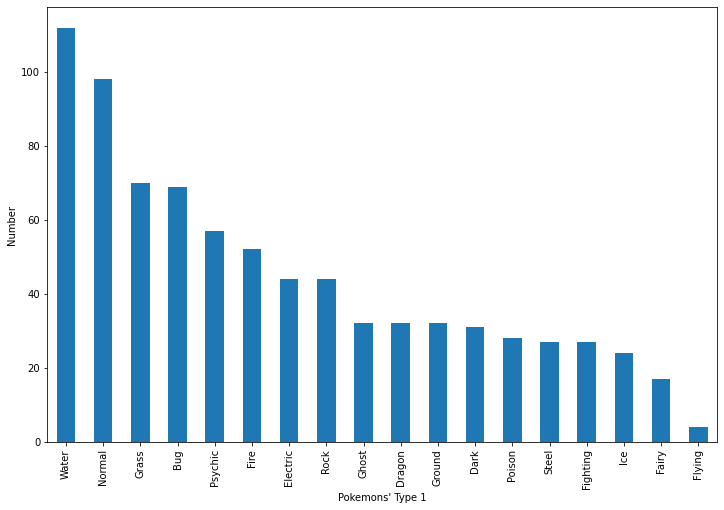

In [9]:
target_s = pokemon_df['Type 1']
"There are {} unique major types".format(target_s.nunique())
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
target_s.value_counts().plot(kind='bar', ax=ax)
ax.set_ylabel('Number')
ax.set_xlabel("Pokemons' Type 1")

Text(0.5, 0, "Pokemons' Type 1")

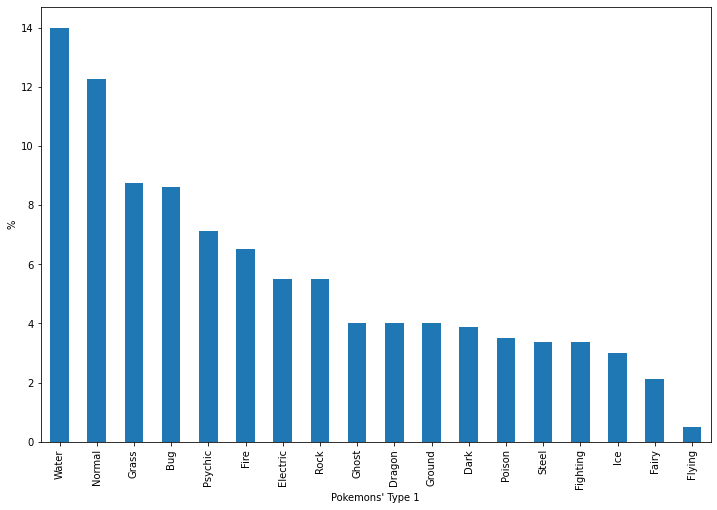

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
target_s.value_counts(normalize=True).mul(100).plot(kind='bar', ax=ax)
ax.set_ylabel('%')
ax.set_xlabel("Pokemons' Type 1")

In [11]:
le = LabelEncoder()
encoded_target_s = pd.Series(le.fit_transform(target_s), name=ENCODED_TARGET_COL)
dummified_target_s = pd.get_dummies(target_s)
dummified_features_df = (pokemon_df.drop(TO_DROP_COLS + [TARGET_COL], axis=1)
                                   .assign(Generation=lambda df: df.Generation.astype(str))
                                   .assign(**{"Legendary": lambda df: df["Legendary"].astype(int), 
                                              "Type 2": lambda df: df["Type 2"].fillna("missing")})
                                   .pipe(pd.get_dummies))
features_and_targets_df = pd.concat([encoded_target_s, dummified_features_df], axis=1)

In [12]:
encoded_target_s.sample(5)

159     2
560    17
452     9
329    16
30      3
Name: encoded_type_1, dtype: int32

In [13]:
le.inverse_transform(encoded_target_s.sample(5))

array(['Electric', 'Water', 'Electric', 'Water', 'Grass'], dtype=object)

In [14]:
dummified_target_s.sample(5)

Bug  Dark  Dragon  Electric  Fairy  Fighting  Fire  Flying  Ghost  Grass  \
457    1     0       0         0      0         0     0       0      0      0   
315    1     0       0         0      0         0     0       0      0      0   
242    0     0       0         0      0         0     0       0      0      0   
548    0     0       0         0      0         0     0       0      0      0   
679    0     0       0         0      0         0     0       0      0      0   

     Ground  Ice  Normal  Poison  Psychic  Rock  Steel  Water  
457       0    0       0       0        0     0      0      0  
315       0    0       0       0        0     0      0      0  
242       0    0       0       0        0     0      0      1  
548       0    0       0       0        0     0      0      1  
679       1    0       0       0        0     0      0      0

In [15]:
dummified_features_df.sample(5)

Total  HP  Attack  Defense  Sp. Atk  Sp. Def  Speed  Legendary  \
122    435  65      55      115      100       40     60          0   
525    535  85      80       70      135       75     90          0   
236    250  40      40       40       70       40     20          0   
584    390  70     105      105       50       40     20          0   
125    295  30      40       70       70       25     60          0   

     Type 2_Bug  Type 2_Dark  ...  Type 2_Rock  Type 2_Steel  Type 2_Water  \
122           0            0  ...            0             0             0   
525           0            0  ...            0             0             0   
236           0            0  ...            0             0             0   
584           0            0  ...            0             0             0   
125           0            0  ...            0             0             0   

     Type 2_missing  Generation_1  Generation_2  Generation_3  Generation_4  \
122               1             1             0             0             0   
525               1             0             0             0             1   
236               1             0             1             0             0   
584               1             0             0             0             0   
125               1             1             0             0             0   

     Generation_5  Generation_6  
122             0             0  
525             0             0  
236             0             0  
584             1             0  
125             0             0  

[5 rows x 33 columns]

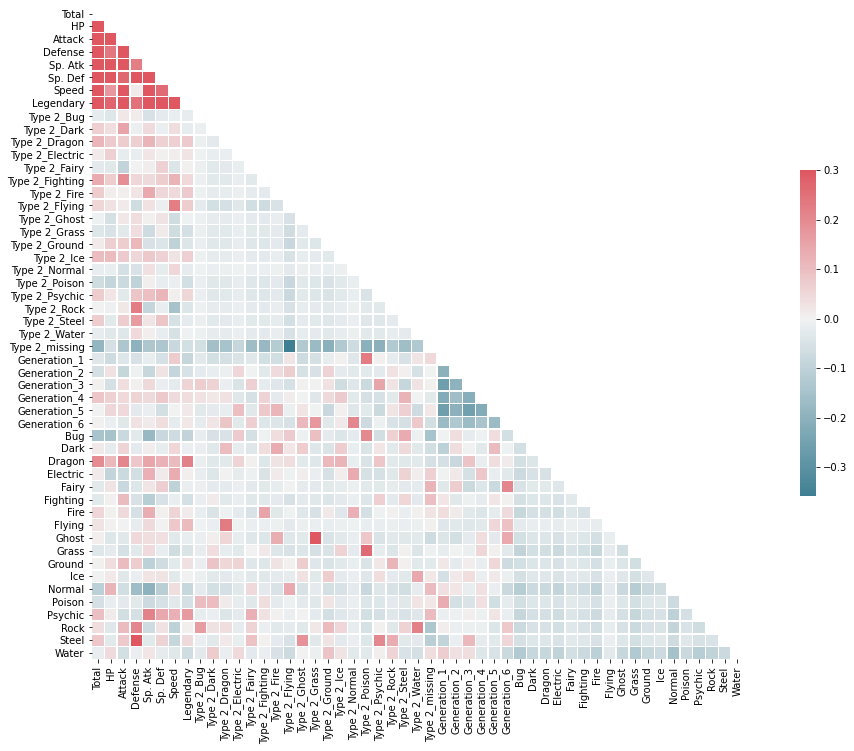

In [16]:
# Inspired from this: https://seaborn.pydata.org/examples/many_pairwise_correlations.html

corr_df = pd.concat([dummified_features_df, dummified_target_s], axis=1).corr()


mask = np.zeros_like(corr_df, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_df, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [17]:
train_df, test_df = train_test_split(features_and_targets_df, 
                                     stratify=encoded_target_s, 
                                     test_size=TEST_RATIO, random_state=SEED)

In [18]:
train_df.head(1).T

526
encoded_type_1    14
Total            518
HP                68
Attack           125
Defense           65
Sp. Atk           65
Sp. Def          115
Speed             80
Legendary          0
Type 2_Bug         0
Type 2_Dark        0
Type 2_Dragon      0
Type 2_Electric    0
Type 2_Fairy       0
Type 2_Fighting    1
Type 2_Fire        0
Type 2_Flying      0
Type 2_Ghost       0
Type 2_Grass       0
Type 2_Ground      0
Type 2_Ice         0
Type 2_Normal      0
Type 2_Poison      0
Type 2_Psychic     0
Type 2_Rock        0
Type 2_Steel       0
Type 2_Water       0
Type 2_missing     0
Generation_1       0
Generation_2       0
Generation_3       0
Generation_4       1
Generation_5       0
Generation_6       0

In [19]:
# The three variations of the F1 score for unbalanced classes are different for unblanaced classes

true_classes = ["a", "b", "c", "a", "c", "c"]
predicted_classes = ["a", "b", "c", "c", "c", "c"]

print("Unbalanced: ")
print("Weighted F1 score:", f1_score(true_classes, predicted_classes, average="weighted"))
print("Micro F1 score:", f1_score(true_classes, predicted_classes, average="micro"))
print("Macro F1 score:", f1_score(true_classes, predicted_classes, average="macro"))

# The three variations of the F1 score for balanced classes are the same

true_classes = ["a", "b", "c", "a", "b", "c"]
predicted_classes = ["a", "b", "c", "a", "b", "c"]
print(32 * "-")

print("Balanaced: ")
print("Weighted F1 score:", f1_score(true_classes, predicted_classes, average="weighted"))
print("Micro F1 score:", f1_score(true_classes, predicted_classes, average="micro"))
print("Macro F1 score:", f1_score(true_classes, predicted_classes, average="macro"))

Unbalanced: 
Weighted F1 score: 0.8174603174603173
Micro F1 score: 0.8333333333333334
Macro F1 score: 0.8412698412698413
--------------------------------
Balanaced: 
Weighted F1 score: 1.0
Micro F1 score: 1.0
Macro F1 score: 1.0


In [20]:
train_features_df = train_df.drop(ENCODED_TARGET_COL, axis=1)
train_target_s = train_df[ENCODED_TARGET_COL]

In [21]:
def improvement_in_percent(model_score, baseline_score):
    return (100 * (model_score - baseline_score)  / baseline_score).round(3)

In [22]:
lr = LogisticRegression(random_state=SEED)
lr_scores = cross_val_score(lr, X=train_features_df, y=train_target_s, cv=5, scoring="f1_weighted")
print("Logistic regression mean and std scores are: ({}, {})".format(lr_scores.mean(), lr_scores.std()))
lr.fit(train_features_df, train_target_s)

Logistic regression mean and std scores are: (nan, nan)


AttributeError: 'str' object has no attribute 'decode'

In [21]:
class HPOptimizer(object):

    def __init__(self):
        # A progress bar to monitor the hyperopt optimization process
        self.pbar = tqdm(total=MAX_EVALS, desc="Hyperopt")
        self.trials = Trials()

    def objective(self, hyperparameters):
        hyperparameters = {
            "max_delta_step": hyperparameters["max_delta_step"],
            "reg_alpha": '{:.3f}'.format(hyperparameters["reg_alpha"]), 
            "reg_lambda": '{:.3f}'.format(hyperparameters["reg_lambda"]), 
            "n_estimators": int(hyperparameters["n_estimators"]), 
            "max_depth": int(hyperparameters["max_depth"]),
            "learning_rate": '{:.3f}'.format(hyperparameters["learning_rate"]), 
            "colsample_bytree": '{:.3f}'.format(hyperparameters['colsample_bytree']),
            "gamma": "{:.3f}".format(hyperparameters['gamma']),
        }
        print("The current hyperparamters are: {}".format(hyperparameters))

        clf = XGBClassifier(
            n_jobs=4,
            **hyperparameters
        )

        scores = cross_val_score(clf, X=train_features_df, y=train_target_s, cv=5, 
                                 scoring="f1_weighted")
        print("Mean and std CV scores are: ({}, {})".format(scores.mean(), scores.std()))
        # Update the progress bar after each iteration
        self.pbar.update()
        # Since we are minimizing the objective => return -1 * mean(scores) (this is a loss)
        return -scores.mean()

    def run(self):
        if RUN_HP_OPTIMIZATION:
            optimal_hp = fmin(fn=objective,
                              space=HP_SPACE,
                              algo=tpe.suggest,
                              trials= trials,
                              max_evals=MAX_EVALS)
        else:
            optimal_hp = OPTIMAL_HP
        self.optimal_hp = optimal_hp

In [22]:
hp_optimizer = HPOptimizer()
hp_optimizer.run()
optimal_hp = hp_optimizer.optimal_hp
print("The optimal hyperparamters are: {}".format(optimal_hp))

Hyperopt:   0%|                                                                                | 0/200 [00:00<?, ?it/s]

The optimal hyperparamters are: {'colsample_bytree': 0.7316836664311229, 'gamma': 0.04744535212276833, 'learning_rate': 0.02478735341127185, 'max_depth': 5.0, 'n_estimators': 349.0, 'reg_alpha': 0.03216806358838591, 'reg_lambda': 0.019055394071559602}


In [23]:
if RUN_HP_OPTIMIZATION:
    hyperaramters_df = pd.DataFrame(trials.idxs_vals[1])
    losses_df = pd.DataFrame(trials.results)
    hyperopt_trials_df = pd.concat([losses_df, hyperaramters_df], axis=1)

In [24]:
if RUN_HP_OPTIMIZATION:
    # Check that the argmin of the hyperopt_trials_df DataFrame is the same as the optimal_hp 
    min_loss_index = losses_df['loss'].argmin()
    assert (hyperaramters_df.loc[min_loss_index, :].to_dict() == optimal_hp)

In [25]:
def hp_vs_loss_scatterplot(hyperparameter):

    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    hyperopt_trials_df.plot(x=hyperparameter, y='loss', kind='scatter', ax=ax)
    best_coordinates = hyperopt_trials_df.loc[min_loss_index, [hyperparameter, "loss"]].values
    ax.annotate("Best {}: {}".format(hyperparameter, round(best_coordinates[0], 3)), 
                xy=best_coordinates, 
                color="red")

In [26]:
if RUN_HP_OPTIMIZATION:
    # Remove the "max_delta_step" since it is fixed for now
    HP_SPACE.pop("max_delta_step")
    for hyperparmeter in HP_SPACE.keys():
        hp_vs_loss_scatterplot(hyperparmeter)

In [27]:
parsed_optimal_hp = {
    "n_estimators": int(optimal_hp["n_estimators"]), 
    "max_depth": int(optimal_hp["max_depth"]),
    "learning_rate": optimal_hp["learning_rate"], 
    "colsample_bytree": '{:.3f}'.format(optimal_hp['colsample_bytree']),
    "gamma": "{:.3f}".format(optimal_hp['gamma']),
}

best_xgb_clf =  XGBClassifier(random_state=SEED, **parsed_optimal_hp)
best_xgb_clf.fit(train_features_df, train_target_s)

[14:07:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree='0.732', gamma='0.047',
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.02478735341127185, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=349, n_jobs=12, num_parallel_tree=1,
              objective='multi:softprob', random_state=31415, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

# random forest

In [29]:
rf_clf = RandomForestClassifier(random_state=SEED)
rf_clf_scores = cross_val_score(rf_clf, X=train_features_df, y=train_target_s, cv=5, scoring="f1_weighted")
print("Simple random forests classification mean and std scores are: ({}, {})".format(rf_clf_scores.mean(), rf_clf_scores.std()))
print("This is a {} % improvement".format(improvement_in_percent(rf_clf_scores.mean(), lr_scores.mean())))

Simple random forests classification mean and std scores are: (0.2573862111461067, 0.053566781256311036)
This is a nan % improvement


In [30]:
nn_clf = MLPClassifier(random_state=SEED)
nn_clf_scores = cross_val_score(nn_clf, X=train_features_df, y=train_target_s, cv=5, scoring="f1_weighted")
print("Simple classification neural network mean and std scores are: ({}, {})".format(nn_clf_scores.mean(), nn_clf_scores.std()))
print("This is a {} % improvement".format(improvement_in_percent(nn_clf_scores.mean(), lr_scores.mean())))

Simple classification neural network mean and std scores are: (0.2506390771474877, 0.060815519711137)
This is a nan % improvement


In [ ]:
TPOT_GENERATION = 10
TPOT_POPULATION_SIZE = 15
# TPOT will have TPOT_POPULATION_SIZE + offspring_size * TPOT_GENERATION runs in total. 
# The offspring_size is set to 100 by default.


tpot_clf = TPOTClassifier(generations=TPOT_GENERATION, population_size=TPOT_POPULATION_SIZE,
                          random_state=SEED, cv=5, 
                          n_jobs=2,
                          verbosity=2, scoring="f1_weighted")
tpot_clf.fit(train_features_df, train_target_s)

Optimization Progress:   0%|          | 0/2050 [00:00<?, ?pipeline/s]

Hyperopt:   0%|                                                                                | 0/200 [03:24<?, ?it/s]


Generation 1 - Current best internal CV score: 0.31706503461438335


Hyperopt:   0%|                                                                                | 0/200 [05:50<?, ?it/s]


Generation 2 - Current best internal CV score: 0.31706503461438335


Hyperopt:   0%|                                                                                | 0/200 [08:32<?, ?it/s]


Generation 3 - Current best internal CV score: 0.31706503461438335


Hyperopt:   0%|                                                                                | 0/200 [13:03<?, ?it/s]


Generation 4 - Current best internal CV score: 0.31706503461438335


Hyperopt:   0%|                                                                                | 0/200 [18:07<?, ?it/s]


Generation 5 - Current best internal CV score: 0.38836783498858896


Hyperopt:   0%|                                                                                | 0/200 [26:10<?, ?it/s]


Generation 6 - Current best internal CV score: 0.38836783498858896


Hyperopt:   0%|                                                                                | 0/200 [32:07<?, ?it/s]


Generation 7 - Current best internal CV score: 0.38836783498858896


Hyperopt:   0%|                                                                                | 0/200 [39:56<?, ?it/s]


Generation 8 - Current best internal CV score: 0.38836783498858896


Hyperopt:   0%|                                                                                | 0/200 [48:15<?, ?it/s]


Generation 9 - Current best internal CV score: 0.38836783498858896


Hyperopt:   0%|                                                                                | 0/200 [59:21<?, ?it/s]


Generation 10 - Current best internal CV score: 0.38836783498858896


Hyperopt:   0%|                                                                              | 0/200 [1:06:18<?, ?it/s]


Generation 11 - Current best internal CV score: 0.38836783498858896


Hyperopt:   0%|                                                                              | 0/200 [1:13:32<?, ?it/s]


Generation 12 - Current best internal CV score: 0.38836783498858896


Hyperopt:   0%|                                                                              | 0/200 [1:20:14<?, ?it/s]


Generation 13 - Current best internal CV score: 0.39106014077811013


Hyperopt:   0%|                                                                              | 0/200 [1:25:49<?, ?it/s]


Generation 14 - Current best internal CV score: 0.39106014077811013


Hyperopt:   0%|                                                                              | 0/200 [1:33:30<?, ?it/s]


Generation 15 - Current best internal CV score: 0.39106014077811013


Hyperopt:   0%|                                                                              | 0/200 [1:44:25<?, ?it/s]


Generation 16 - Current best internal CV score: 0.39106014077811013


Hyperopt:   0%|                                                                              | 0/200 [1:52:19<?, ?it/s]


Generation 17 - Current best internal CV score: 0.3934388318535695


Hyperopt:   0%|                                                                              | 0/200 [1:59:14<?, ?it/s]


Generation 18 - Current best internal CV score: 0.4189944810788294


Hyperopt:   0%|                                                                              | 0/200 [2:07:32<?, ?it/s]


Generation 19 - Current best internal CV score: 0.4189944810788294


Hyperopt:   0%|                                                                              | 0/200 [2:17:26<?, ?it/s]


Generation 20 - Current best internal CV score: 0.4189944810788294


Hyperopt:   0%|                                                                              | 0/200 [2:27:43<?, ?it/s]


Generation 21 - Current best internal CV score: 0.4189944810788294


Hyperopt:   0%|                                                                              | 0/200 [2:39:05<?, ?it/s]


Generation 22 - Current best internal CV score: 0.4189944810788294


In [49]:
test_features_df = test_df.drop(ENCODED_TARGET_COL, axis=1)
encoded_test_targets_s = test_df[ENCODED_TARGET_COL]

In [50]:
def test_evaluation(clf):
    """
    Evaluate a classifier on the test dataset. Returns a confusion matrix and F1 score. 
    """
    encoded_test_predictions_s = clf.predict(test_features_df)
    test_predictions_s = pd.Series(le.inverse_transform(encoded_test_predictions_s), 
                                   name="predicted_type_1")
    test_targets_s = pd.Series(le.inverse_transform(encoded_test_targets_s), 
                               name="true_type_1")
    test_cm = confusion_matrix(test_targets_s, test_predictions_s)
    test_f1_score = f1_score(test_targets_s, test_predictions_s, average='weighted').round(3)
    return test_cm, test_f1_score

In [60]:
test_cm_tpot, test_f1_score_tpot = test_evaluation(tpot_clf)
test_cm_best_xgb, test_f1_score_best_xgb = test_evaluation(best_xgb_clf)
test_cm_lr, test_f1_score_lr = test_evaluation(lr)

AttributeError: 'list' object has no attribute 'shape'

In [61]:
print("Tpot test F1 weighted score is {}".format(test_f1_score_tpot))
print("Best XGBoost test F1 weighted score is {}".format(test_f1_score_best_xgb))
print("Logistic regression test F1 weighted score is {}".format(test_f1_score_lr))

Tpot test F1 weighted score is 0.25
Best XGBoost test F1 weighted score is 0.376


NameError: name 'test_f1_score_lr' is not defined

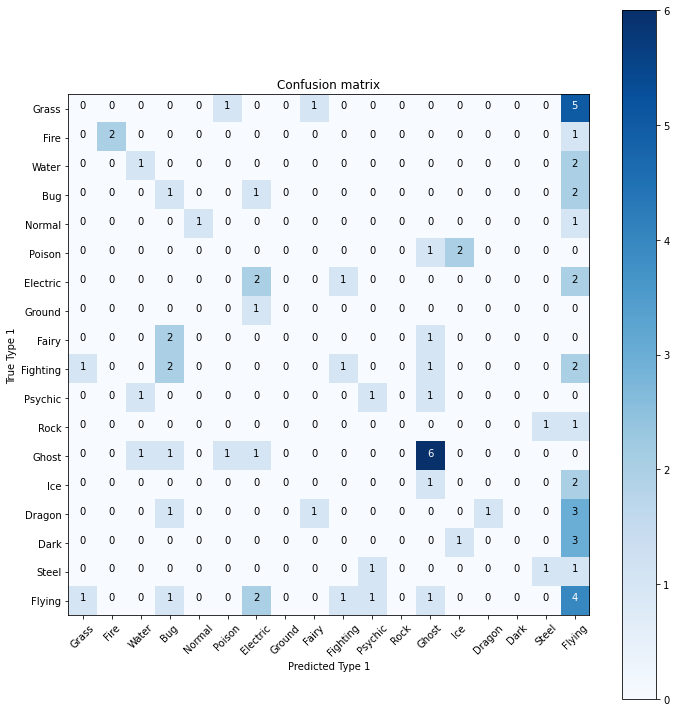

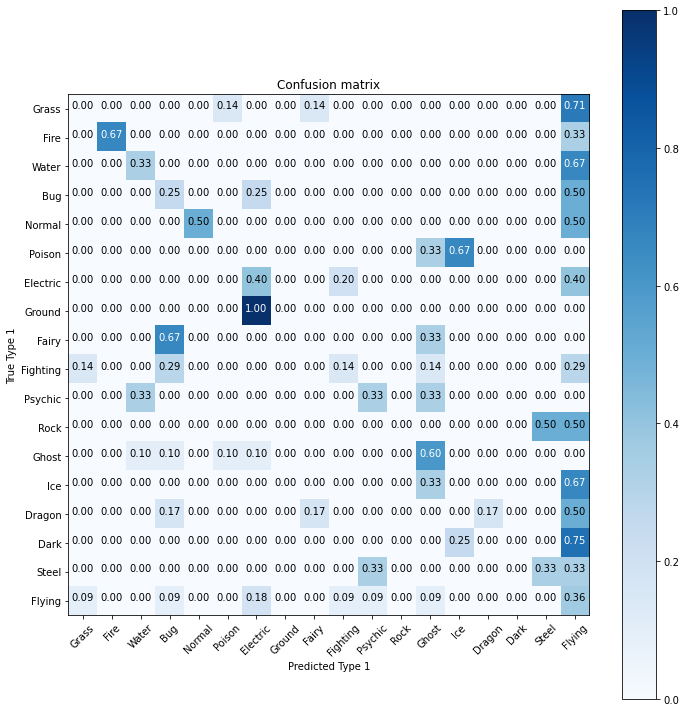

In [63]:
# Confusion matrix for Tpot
plot_confusion_matrix(test_cm_tpot, classes=target_s.unique())
plot_confusion_matrix(test_cm_tpot, classes=target_s.unique(), normalize=True)